In [ ]:
import sys
!{sys.executable} -m pip install tensorflow --user
!{sys.executable} -m pip install imageio --user

In [4]:
!{sys.executable} -m pip show tensorflow

Name: tensorflow
Version: 2.5.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\alif-\appdata\roaming\python\python38\site-packages
Requires: wheel, protobuf, flatbuffers, numpy, keras-preprocessing, opt-einsum, termcolor, typing-extensions, gast, absl-py, keras-nightly, astunparse, h5py, six, tensorflow-estimator, google-pasta, tensorboard, grpcio, wrapt
Required-by: 


In [5]:
import os
os.getcwd() 

'C:\\Users\\alif-\\Projects\\deep-learning\\tf-hand-signs'

In [13]:
import sys
sys.path.append('C:\\users\\alif-\\appdata\\roaming\\python\\python38\\site-packages')
sys.path.append('C:\\users\\alif-\\anaconda3\\lib\\site-packages')

In [15]:
import h5py
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.framework.ops import EagerTensor
from tensorflow.python.ops.resource_variable_ops import ResourceVariable
import time
import imageio

In [8]:
train_set = h5py.File('data/train_signs.h5', "r")
test_set = h5py.File('data/test_signs.h5', "r")

In [9]:
[key for key in train_set.keys()]

['list_classes', 'train_set_x', 'train_set_y']

In [108]:
dataset_train_x = train_set['train_set_x']
data_train_x = np.array(tsetx[:,:,:])
print(data_train_x[1].shape)

(64, 64, 3)


In [109]:
dataset_train_y = train_set['train_set_y']
data_train_y = np.array(dataset_train_y[:])
print(data_train_y[1])

0


In [16]:
file = 'test.png' # or .jpg
imageio.imwrite(file, data[1])

2


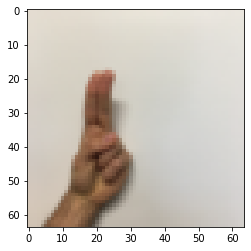

In [123]:
ex_num = 10
plt.imshow(data_train_x[ex_num])
print(data_train_y[ex_num])

In [21]:
train_x = tf.data.Dataset.from_tensor_slices(train_set['train_set_x'])
train_y = tf.data.Dataset.from_tensor_slices(train_set['train_set_y'])

In [22]:
[key for key in test_set.keys()]

['list_classes', 'test_set_x', 'test_set_y']

In [24]:
test_x = tf.data.Dataset.from_tensor_slices(test_set['test_set_x'])
test_y = tf.data.Dataset.from_tensor_slices(test_set['test_set_y'])

In [25]:
type(train_x)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [26]:
print(train_y.element_spec)

TensorSpec(shape=(), dtype=tf.int64, name=None)


In [27]:
for element in train_x:
    print(element)
    break

tf.Tensor(
[[[227 220 214]
  [227 221 215]
  [227 222 215]
  ...
  [232 230 224]
  [231 229 222]
  [230 229 221]]

 [[227 221 214]
  [227 221 215]
  [228 221 215]
  ...
  [232 230 224]
  [231 229 222]
  [231 229 221]]

 [[227 221 214]
  [227 221 214]
  [227 221 215]
  ...
  [232 230 224]
  [231 229 223]
  [230 229 221]]

 ...

 [[119  81  51]
  [124  85  55]
  [127  87  58]
  ...
  [210 211 211]
  [211 212 210]
  [210 211 210]]

 [[119  79  51]
  [124  84  55]
  [126  85  56]
  ...
  [210 211 210]
  [210 211 210]
  [209 210 209]]

 [[119  81  51]
  [123  83  55]
  [122  82  54]
  ...
  [209 210 210]
  [209 210 209]
  [208 209 209]]], shape=(64, 64, 3), dtype=uint8)


In [28]:
def unroll(image):
    image = tf.cast(image, tf.float32) / 256.0
    image = tf.reshape(image, [-1,1])
    return image

In [29]:
unroll_train = train_x.map(unroll)
unroll_test = test_x.map(unroll)

In [30]:
unroll_train.element_spec

TensorSpec(shape=(12288, 1), dtype=tf.float32, name=None)

In [31]:
print(next(iter(unroll_train)))

tf.Tensor(
[[0.88671875]
 [0.859375  ]
 [0.8359375 ]
 ...
 [0.8125    ]
 [0.81640625]
 [0.81640625]], shape=(12288, 1), dtype=float32)


In [53]:
def one_hot(label, depth=6):
    one_hot = tf.reshape(tf.one_hot(label, depth, axis=0), (depth, 1))
    return one_hot

In [55]:
oh_test_y = test_y.map(one_hot)
oh_train_y = train_y.map(one_hot)

In [96]:
def initialize():
    initializer = tf.keras.initializers.GlorotNormal(seed=1)
    
    W1 = tf.Variable(initializer(shape=(25,12288)))
    b1 = tf.Variable(initializer(shape=(25,1)))
    W2 = tf.Variable(initializer(shape=(12, 25)))
    b2 = tf.Variable(initializer(shape=(12, 1)))
    W3 = tf.Variable(initializer(shape=(6, 12)))
    b3 = tf.Variable(initializer(shape=(6, 1)))
    
    parameters = {
        "W1": W1,
        "b1": b1,
        "W2": W2,
        "b2": b2,
        "W3": W3,
        "b3": b3
    }
    
    return parameters

In [97]:
parameters = initialize()

In [98]:
@tf.function
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    
    Z1 = tf.add(tf.linalg.matmul(W1, X), b1)
    A1 = tf.keras.activations.relu(Z1)
    Z2 = tf.add(tf.linalg.matmul(W2, A1), b2)
    A2 = tf.keras.activations.relu(Z2)
    Z3 = tf.add(tf.linalg.matmul(W3, A2), b3)
    
    return Z3

In [50]:
@tf.function
def compute_cost(true, pred):
    cost = tf.reduce_mean(tf.keras.losses.binary_crossentropy(y_true = true, y_pred = pred, from_logits=True))
    return cost

In [146]:
def model(train_x, train_y, test_x, test_y, alpha = 0.0001, epochs = 1500, minibatch_size = 32):
    costs = []
    parameters = initialize()
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    optimizer = tf.keras.optimizers.SGD(alpha)
    
    train_x = train_x.batch(minibatch_size, drop_remainder=True).prefetch(8)
    train_y = train_y.batch(minibatch_size, drop_remainder=True).prefetch(8)
    
    for epoch in range(epochs):
        epoch_cost = 0.
        for (minibatch_x, minibatch_y) in zip(train_x, train_y):
            with tf.GradientTape() as tape:
                Z3 = forward_propogation(minibatch_x, parameters)
                minibatch_cost = compute_cost(minibatch_y, Z3)
            
            trainable_vars = [W1, b1, W2, b2, W3, b3]
            grads = tape.gradient(minibatch_cost, trainable_vars)
            optimizer.apply_gradients(zip(grads, trainable_vars))
            epoch_cost += minibatch_cost / minibatch_size
        
        if epoch % 50 == 0:
            print("Cost after epoch %i: %f" % (epoch, epoch_cost))
        if epoch % 10 == 0:
            costs.append(epoch_cost)
            
    plt.plot(np.squeeze(costs))
    plt.ylabel("cost")
    plt.xlabel("iterations")
    plt.title("Learning rate (alpha) = " + str(alpha))
    plt.show()
    
    print("Neural network has been trained :)")
    
    return parameters

Cost after epoch 0: 0.742591
Cost after epoch 50: 0.570628
Cost after epoch 100: 0.478259
Cost after epoch 150: 0.461677
Cost after epoch 200: 0.454389
Cost after epoch 250: 0.448733
Cost after epoch 300: 0.443804
Cost after epoch 350: 0.439379
Cost after epoch 400: 0.435242
Cost after epoch 450: 0.431319
Cost after epoch 500: 0.427482
Cost after epoch 550: 0.423722
Cost after epoch 600: 0.420121
Cost after epoch 650: 0.416455
Cost after epoch 700: 0.412911
Cost after epoch 750: 0.409474
Cost after epoch 800: 0.406121
Cost after epoch 850: 0.402855
Cost after epoch 900: 0.399664
Cost after epoch 950: 0.396548
Cost after epoch 1000: 0.393498
Cost after epoch 1050: 0.390507
Cost after epoch 1100: 0.387572
Cost after epoch 1150: 0.384689
Cost after epoch 1200: 0.381858
Cost after epoch 1250: 0.379065
Cost after epoch 1300: 0.376318
Cost after epoch 1350: 0.373627
Cost after epoch 1400: 0.370976
Cost after epoch 1450: 0.368374


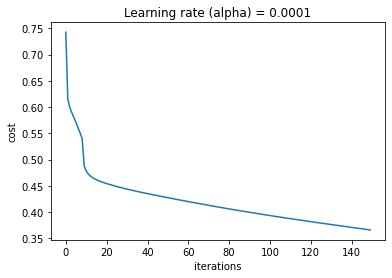

Neural network has been trained :)


In [147]:
trained_params = model(unroll_train, oh_train_y, unroll_test, oh_test_y, epochs=1500)

In [181]:
test_ex = 10

In [182]:
test_Z3 = forward_propogation(unroll(data_train_x[test_ex]), trained_params)
print(test_Z3)

tf.Tensor(
[[-1.7616302]
 [-1.913258 ]
 [-1.5660504]
 [-2.1797438]
 [-1.5808117]
 [-1.7054181]], shape=(6, 1), dtype=float32)


In [183]:
test_A3 = tf.keras.activations.sigmoid(test_Z3)
print(test_A3)

tf.Tensor(
[[0.14658627]
 [0.12861526]
 [0.17278016]
 [0.10158426]
 [0.17068055]
 [0.15375894]], shape=(6, 1), dtype=float32)


In [184]:
print("Predicted number: %i" % np.argmax(np.squeeze(test_A3)))

Predicted number: 2


Actual number: 2


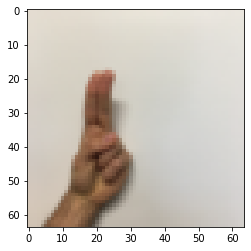

In [185]:
plt.imshow(data_train_x[test_ex])
print("Actual number: %i" % data_train_y[test_ex])